In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tkinter as tk
import tkinter.filedialog as fd

In [2]:
#filename = askopenfilename() # Browse for file
root = tk.Tk()
filez = fd.askopenfilenames(parent=root, title='Choose files')

In [3]:
original_input_data = pd.DataFrame()
original_target_data = pd.DataFrame()
for value in iter(filez):
    df = pd.read_csv(value) # Store data in file
    X_read = df[:-1]
    Y_read = pd.DataFrame(np.array([df["GLUCOSE CONC"][1:], 
                           df["GLUTAMINE CONC"][1:], 
                           df["AMMONIA CONC"][1:], 
                           df["INHIBITOR SAT"][1:], 
                           df["TOTAL CELL DENSITY"][1:], 
                           df["VIABLE CELL DENSITY"][1:], 
                           df["DEAD CELL DENSITY"][1:], 
                           df["INHIBITOR SAT"][1:]]).T)
    original_input_data = pd.concat([original_input_data,X_read], ignore_index=True)
    original_target_data = pd.concat([original_target_data,Y_read], ignore_index=True)

In [4]:
# Step 1: Normalization
scaler_input = StandardScaler()
scaler_target = StandardScaler()
normalized_input_data = scaler_input.fit_transform(original_input_data)
normalized_target_data = scaler_target.fit_transform(original_target_data)


In [5]:
# Step 2: Randomization
indices = np.arange(len(normalized_input_data))
np.random.shuffle(indices)

# Keep track of the permutation indices
inverse_indices = np.argsort(indices)

# Apply the same random order to both input and target datasets
randomized_input_data = normalized_input_data[indices]
randomized_target_data = normalized_target_data[indices]

print(randomized_input_data.shape)
print(randomized_target_data.shape)

(107900, 30)
(107900, 8)


In [12]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert NumPy arrays to PyTorch tensors
input_train_numpy, input_test_numpy, target_train_numpy, target_test_numpy = train_test_split(randomized_input_data, randomized_target_data, test_size=0.3, random_state=42)

# Ensure NumPy arrays and check shapes
input_train_numpy = np.array(input_train_numpy)
target_train_numpy = np.array(target_train_numpy)
print(f"Training set size: {input_train_numpy.shape[0]}")
print(f"Test set size: {input_test_numpy.shape[0]}")

# Hyper-parameters
input_size = input_train_numpy.shape[1]
hidden_size = [100, 1000, 20]  # Adjust the hidden layer sizes as needed
batch_size = 500
num_epochs = 5
learning_rate = .001
output_size_regression = 8  # For binary classification

# format the train and test datasets
train_dataset = torch.utils.data.TensorDataset(torch.tensor(input_train_numpy, dtype=torch.float32), torch.tensor(target_train_numpy, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(input_test_numpy, dtype=torch.float32), torch.tensor(target_test_numpy, dtype=torch.float32))

# Create training DataLoader for batch processing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set size: 75530
Test set size: 32370


In [7]:
# Define the neural network architecture
class NeuralNetworkRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetworkRegression, self).__init__()
        self.layers = nn.ModuleList() # Used to store layers
        layer_sizes = [input_size] + hidden_size + [output_size]

        for i in range(len(layer_sizes) - 1):
            linear_layer = nn.Linear(layer_sizes[i], layer_sizes[i+1])
            nn.init.xavier_uniform_(linear_layer.weight)  # Apply Xavier/Glorot initialization
            self.layers.append(linear_layer)

            if i < len(layer_sizes) - 2:
                # Add BatchNorm after each linear layer except the last one
                self.layers.append(nn.BatchNorm1d(layer_sizes[i+1]))
                # Use Leaky ReLU activation
                self.layers.append(nn.LeakyReLU(negative_slope=0.01))

        # No activation function on the final output layer for regression
        self.layers[-1] = nn.Linear(layer_sizes[-2], layer_sizes[-1])

    def forward(self, x):
        #return self.model(x)  # Use sigmoid activation for binary classification
        for layer in self.layers:
            x = layer(x)
        return(x)

Epoch [1/5], Step [94/152] Loss: 0.03004429303109646
Epoch [2/5], Step [94/152] Loss: 0.002830194542184472
Epoch [3/5], Step [94/152] Loss: 0.0013670928310602903
Epoch [4/5], Step [94/152] Loss: 0.002905766014009714
Epoch [5/5], Step [94/152] Loss: 0.007165065500885248
Overall Training MSE: 0.037504342119714956
Overall Test MSE: 0.0015765025549066755
Overall Training MAE: 0.09133607894182205
Overall Test MAE: 0.02881169505417347
Overall Training R-squared: 0.9624083757016004
Overall Test R-squared: 0.9984232463546652


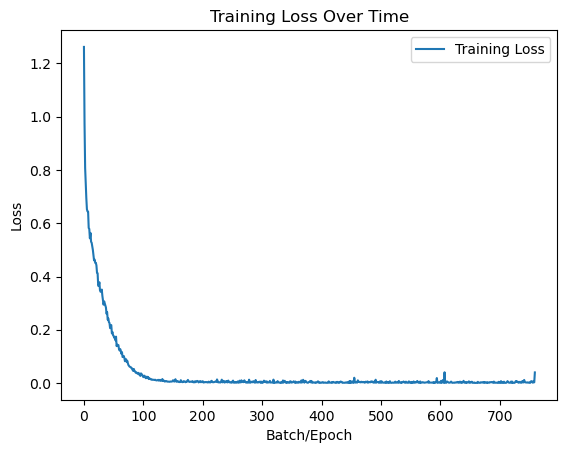

In [13]:
model_regression = NeuralNetworkRegression(input_size, hidden_size, output_size_regression).to(device) #change to immutable?

# Lists to store original and predicted values
original_values_train = []
predicted_values_train = []
original_values_test = []
predicted_values_test = []

# Lists to store training and validation losses
train_losses = []
test_losses = []

# Define the loss function and optimizer for regression
loss = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer_regression = torch.optim.Adam(model_regression.parameters(), lr=learning_rate)

# Training loop
n_total_steps = len(train_loader)
for epoch in range(num_epochs):

    model_regression.train()
    for i, (inputs, targets) in enumerate(train_loader):

        # Switch where the tensors get executed (GPU if available)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Check input size
        assert input_size == inputs.shape[1], "Input size mismatch!"

        # Predict: Forward pass
        outputs = model_regression(inputs)
        # Ensure output size matches the model's output layer
        assert output_size_regression == outputs.shape[1], "Output size mismatch!"

        #loss
        cost = loss(outputs, targets)

        # calculate gradients: Backward pass and optimization
        cost.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model_regression.parameters(), max_norm=1.0)

        # update weights
        optimizer_regression.step()

        # zero the gradients after updating
        optimizer_regression.zero_grad()

        # append the training loss the the list
        train_losses.append(cost.item())

        # Store original and predicted values for further analysis if needed
        with torch.no_grad():
            original_values_train.extend(targets.cpu().numpy())
            predicted_values_train.extend(outputs.cpu().numpy())

        if (i+1) % 95 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{n_total_steps}] Loss: {cost}')
        
        # Evaluate on the entire training set at the end of each epoch
    model_regression.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model_regression(inputs)

            # Calculate MSE
            mse = nn.MSELoss()(outputs, targets)

            # Append to the list
            test_losses.append(mse.item())

            # Store original and predicted values for further analysis if needed
            original_values_test.extend(targets.cpu().numpy())
            predicted_values_test.extend(outputs.cpu().numpy())

# Calculate overall training and validation MSE
overall_train_mse = sum(train_losses) / len(train_losses)
overall_test_mse = sum(test_losses) / len(test_losses)

# Calculate additional metrics: MAE and R-squared
mae_train = np.mean(np.abs(np.array(predicted_values_train) - np.array(original_values_train)))
mae_test = np.mean(np.abs(np.array(predicted_values_test) - np.array(original_values_test)))

r2_train = r2_score(original_values_train, predicted_values_train)
r2_test = r2_score(original_values_test, predicted_values_test)

print(f'Overall Training MSE: {overall_train_mse}')
print(f'Overall Test MSE: {overall_test_mse}')
print(f'Overall Training MAE: {mae_train}')
print(f'Overall Test MAE: {mae_test}')
print(f'Overall Training R-squared: {r2_train}')
print(f'Overall Test R-squared: {r2_test}')

# Plotting the training loss
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Batch/Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

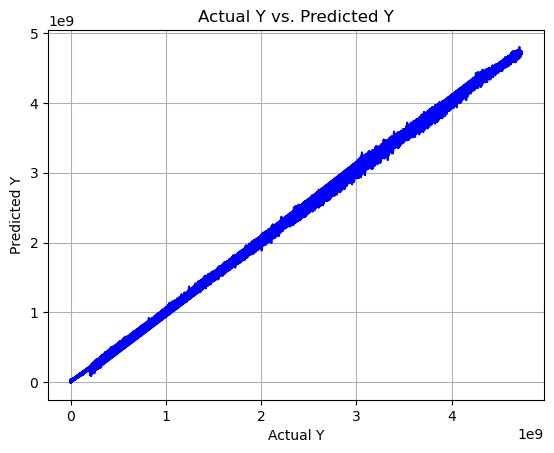

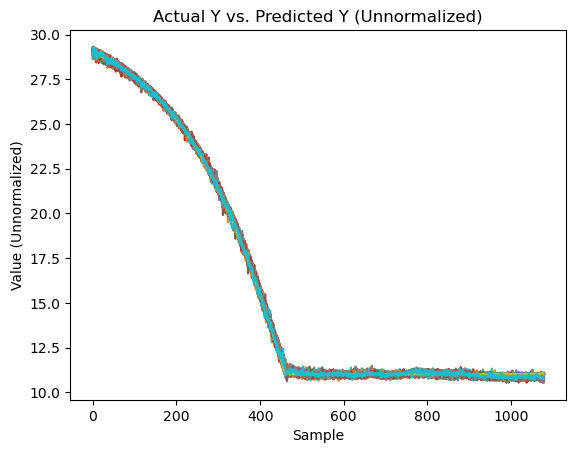

In [16]:
# Apply the inverse permutation indices
unrandomized_input_data = randomized_input_data[inverse_indices]
unrandomized_target_data = randomized_target_data[inverse_indices]

predicted_normalized_target_data = model_regression(torch.tensor(unrandomized_input_data, dtype=torch.float32))
predicted_target_data_final = predicted_normalized_target_data.detach().numpy()

predicted_original_values = scaler_target.inverse_transform(unrandomized_target_data)
predicted_target_values = scaler_target.inverse_transform(predicted_target_data_final)

# Scatter plot
plt.plot(predicted_original_values, predicted_target_values, color='blue', markersize=.0001)
plt.xlabel('Actual Y')
plt.ylabel('Predicted Y')
plt.title('Actual Y vs. Predicted Y')
plt.grid()
plt.show()
# Alternatively, you can use a line plot for a visual comparison
start = 1
offset = 100
for i in range(start,offset + start):
    plt.plot(predicted_original_values.T[0][((i-1)*1079):(i*1079)], label='Actual', marker='o', markersize=.01)
    plt.plot(predicted_target_values.T[0][((i-1)*1079):(i*1079)], label='Predicted', marker='x',markersize=.01)
plt.xlabel('Sample')
plt.ylabel('Value (Unnormalized)')
plt.title('Actual Y vs. Predicted Y (Unnormalized)')
# plt.legend()
plt.show()